In [191]:
!pip install medmnist


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score
import medmnist
from medmnist import INFO, Evaluator
from DNN import DNN
from fit import fit
from fit import evaluate_nn

In [193]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We work on the 2D dataset with size 28x28

In [2]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [3]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


In [196]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\PC\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License

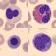

In [197]:
# visualization

train_dataset.montage(length=2)



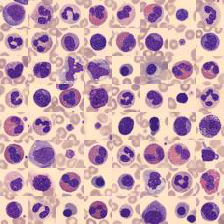

In [198]:

train_dataset.montage(length=8)

In [ ]:
#Access a single image / label
image, label = train_dataset[2]  # image is a tensor , label is an  int
print("Shape da imagem:", image.shape)
print("Classe:", label)

# Convert to NumPy array
image_array = image.numpy()
print("Size:", image_array.shape )

#Access a subset of images
img = train_dataset[1][0].numpy   # image
lab = train_dataset[1][1]   # label
start_idx = 10
end_idx = 20  # exclusive
images_array = np.stack([train_dataset[i][0].numpy() for i in range(start_idx, end_idx)])
labels_array = np.array([train_dataset[i][1] for i in range(start_idx, end_idx)])

print("Size:", images_array.shape )
print(labels_array)

Shape da imagem: torch.Size([3, 28, 28])
Classe: [6]
Size: (3, 28, 28)
Size: (10, 3, 28, 28)
[[1]
 [1]
 [6]
 [7]
 [6]
 [3]
 [7]
 [2]
 [6]
 [1]]


In [8]:



num_inputs = 28 * 28 * 3
num_classes = 8
hidden_layer_sizes = (128,) * 2 # 1 hidden layer
n_epochs = 30

dnn = DNN(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
dnn2 = DNN(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(dnn.parameters(), lr=0.001)
optimizerSGD = optim.SGD(dnn2.parameters(), lr=0.01, momentum=0.5)
dnn = fit(train_loader, dnn, criterion, optimizerAdam, n_epochs)
dnn2 = fit(train_loader, dnn2, criterion, optimizerSGD, n_epochs)
evaluate_nn(dnn, test_loader)
evaluate_nn(dnn2, test_loader)


Epoch [1/30], Loss: 1.4216
Epoch [2/30], Loss: 0.9660
Epoch [3/30], Loss: 0.8722
Epoch [4/30], Loss: 0.8082
Epoch [5/30], Loss: 0.7622
Epoch [6/30], Loss: 0.7291
Epoch [7/30], Loss: 0.6896
Epoch [8/30], Loss: 0.6621
Epoch [9/30], Loss: 0.6217
Epoch [10/30], Loss: 0.5834
Epoch [11/30], Loss: 0.6027
Epoch [12/30], Loss: 0.5709
Epoch [13/30], Loss: 0.5464
Epoch [14/30], Loss: 0.5329
Epoch [15/30], Loss: 0.5642
Epoch [16/30], Loss: 0.5262
Epoch [17/30], Loss: 0.5084
Epoch [18/30], Loss: 0.5121
Epoch [19/30], Loss: 0.4795
Epoch [20/30], Loss: 0.4798
Epoch [21/30], Loss: 0.4794
Epoch [22/30], Loss: 0.4740
Epoch [23/30], Loss: 0.4679
Epoch [24/30], Loss: 0.5134
Epoch [25/30], Loss: 0.4651
Epoch [26/30], Loss: 0.4472
Epoch [27/30], Loss: 0.4378
Epoch [28/30], Loss: 0.4430
Epoch [29/30], Loss: 0.4361
Epoch [30/30], Loss: 0.4235
Epoch [1/30], Loss: 1.9527
Epoch [2/30], Loss: 1.6200
Epoch [3/30], Loss: 1.3584
Epoch [4/30], Loss: 1.2135
Epoch [5/30], Loss: 1.1024
Epoch [6/30], Loss: 1.0563
Epoch [